# Librairies

In [2]:
library('igraph')
library('orca') 
require(ggplot2)
require(reshape2) 
library(dplyr)

# Data Description

In [4]:
#Read the data from a csv
rm(datafile)
datafile <- read.csv2("mentions_datafile.csv")

#change column names
colnames(datafile) <- c("creation_date","user1","user2","time_interval","frequency")
head(datafile)


,creation_date,user1,user2,time_interval,frequency
,<fct>,<dbl>,<dbl>,<int>,<int>
1,2019-10-28 00:00:00,1.111153e+08,2.222890e+09,436727,1
2,2019-10-28 00:00:00,1.111153e+08,2.222991e+06,436727,1
3,2019-10-28 01:00:00,1.111155e+08,2.222032e+07,436728,1
4,2019-10-28 03:00:00,1.111715e+17,2.222607e+18,436730,1
5,2019-10-28 03:00:00,1.111715e+17,2.222626e+07,436730,1
6,2019-10-28 03:00:00,1.111715e+17,2.222043e+09,436730,1


# Count number of interactions between entities, per date

## Count corresponding interactions

In [5]:
count_interactions <- plyr::count(datafile, "creation_date")

#change column names
colnames(count_interactions) <- c("creation_date", "nb_interactions")

#print order by datee
tail(count_interactions[order(count_interactions$creation_date),])

,creation_date,nb_interactions
,<fct>,<int>
64,2019-10-30 18:00:00,542
65,2019-10-30 19:00:00,532
66,2019-10-30 20:00:00,400
67,2019-10-30 21:00:00,340
68,2019-10-30 22:00:00,249
69,2019-10-30 23:00:00,145


# Time series

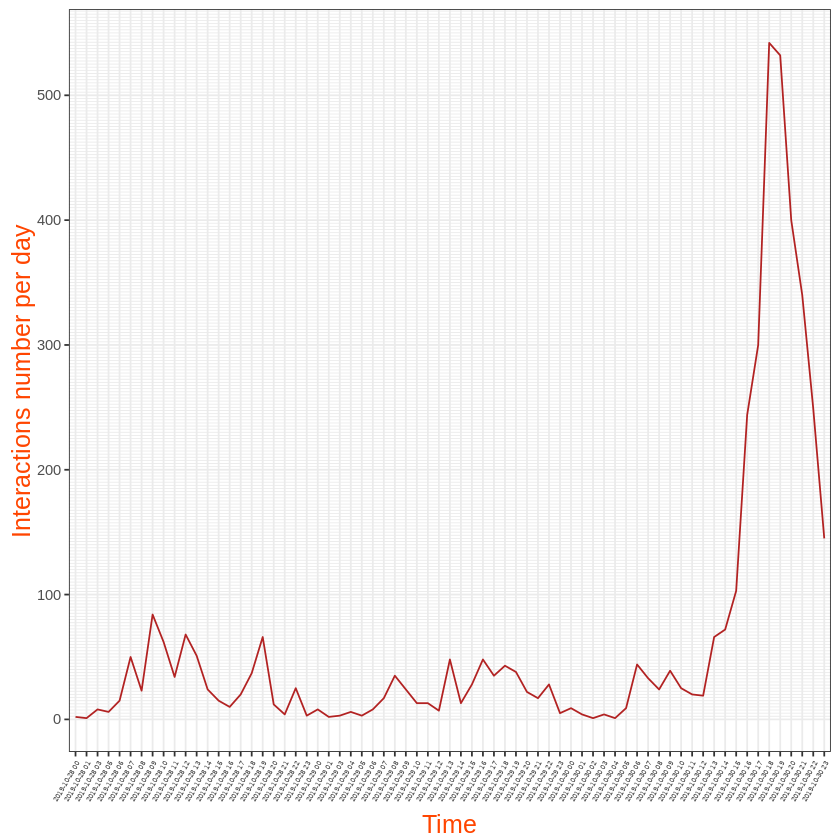

In [6]:
theme_set(theme_bw())

ggplot(count_interactions, aes(substr(creation_date,1,13), nb_interactions, group = 1)) + 
  geom_line(color="firebrick")+
labs(x="Time", y="Interactions number per day") +

 theme(axis.text.x=element_text(angle=60, hjust=1,size = rel(0.5))) +
theme(axis.title.x = element_text(color = "orangered",
                                    size = 15, vjust = -0.35),
        axis.title.y = element_text(color = "orangered",
                                    size = 15, vjust = 0.35))+
  scale_y_continuous(breaks = seq(0, 700, 100),
                     minor_breaks = seq(0, 5000, 2.5))  


# Preliminary graphlet counting functions

In [7]:
graph_to_indexed_edges <- function(graph) {
  # Use igraph method to get edge list with edges specified using vertex ID 
  # (indexes) rather than names
  edges <- igraph::get.edgelist(graph, names = FALSE)
  # Convert edge list from numeric to integer
  edges <- structure(vapply(edges, as.integer, integer(1)), dim = dim(edges))
  colnames(edges) <- c("Node A index", "Node B index")
  node_vertex_names <- igraph::get.vertex.attribute(graph, name = "name")
  attr(edges, "vertex_names") <- node_vertex_names
  return(edges)
}


orbit_key <- function(max_graphlet_size) {
  if(max_graphlet_size == 2) {
    node_count <- c(2)
  } else if(max_graphlet_size == 3) {
    node_count <- c(2, rep(3,3))
  } else if(max_graphlet_size == 4) {
    node_count <- c(2, rep(3,3), rep(4,11))
  } else if (max_graphlet_size == 5) {
    node_count <- c(2, rep(3,3), rep(4,11), rep(5, 58))
  } else {
    stop("Unsupported maximum graphlet size")
  }
  max_node_index <- length(node_count)-1
  id <- purrr::simplify(purrr::map(0:max_node_index, function(index) {
    paste('O', index, sep = "")}))
  name <- 
    return(list(max_nodes = max_graphlet_size, id = id, node_count = node_count))
}


count_orbits_per_node <- function(graph, max_graphlet_size) {
  if(max_graphlet_size == 4) {
    orca_fn <- orca::count4
  } else if(max_graphlet_size == 5) {
    orca_fn <- orca::count5
  } else {
    stop("Unsupported maximum graphlet size")
  }
  indexed_edges <- graph_to_indexed_edges(graph)
  num_edges <- dim(indexed_edges)[[1]]
  if(num_edges >= 1) {
    orbit_counts <- orca_fn(indexed_edges)
  } else {
    # ORCA functions expect at least one edge, so handle this case separately
    # and manually construct empty orbit count matrix
    orbit_ids <- orbit_key(max_graphlet_size)$id
    num_orbits <- length(orbit_ids)
    num_nodes <- igraph::vcount(graph)
    orbit_counts <- matrix(0, nrow = num_nodes, ncol = num_orbits)
    colnames(orbit_counts) <- orbit_ids
  }
  rownames(orbit_counts) <- igraph::get.vertex.attribute(graph, name = "name")
  return(orbit_counts)
}


graphlet_key <- function(max_graphlet_size) {
  if(max_graphlet_size == 2) {
    node_count <- c(2)
  } else if(max_graphlet_size == 3) {
    node_count <- c(2, rep(3,2))
  } else if(max_graphlet_size == 4) {
    node_count <- c(2, rep(3,2), rep(4,6))
  } else if (max_graphlet_size == 5) {
    node_count <- c(2, rep(3,2), rep(4,6), rep(5, 21))
  } else {
    stop("Unsupported maximum graphlet size")
  }
  max_node_index <- length(node_count)-1
  id <- purrr::simplify(purrr::map(0:max_node_index, function(index) {
    paste('G', index, sep = "")}))
  name <- 
    return(list(max_nodes = max_graphlet_size, id = id, node_count = node_count))
}



orbit_to_graphlet_counts <- function(orbit_counts) {
  num_orbits <- dim(orbit_counts)[2]
  # Indexes to select the orbit(s) that comprise each graphlet. Note that we 
  # define these in the zero-based indexing used in journal papers, but 
  # need to add 1 to convert to the 1-based indexing used by R
  if(num_orbits == 15) {
    # Orbits for graphlets comprising up to 4 nodes
    max_nodes <- 4
    orbit_to_graphlet_map <- 
      purrr::map(list(0, 1:2, 3, 4:5, 6:7, 8, 9:11, 12:13, 14), 
                 function(indexes){ indexes + 1})
  } else if(num_orbits == 73) {
    # Orbits for graphlets comprising up to 5 nodes
    max_nodes <- 5
    orbit_to_graphlet_map <- 
      purrr::map(list(0, 1:2, 3, 4:5, 6:7, 8, 9:11, 12:13, 14, 15:17, 18:21, 
                      22:23, 24:26, 27:30, 31:33, 34, 35:38, 39:42, 43:44, 
                      45:48, 49:50, 51:53, 54:55, 56:58, 59:61, 62:64, 
                      65:67, 68:69, 70:71, 72), 
                 function(indexes){ indexes + 1})
  } else {
    stop(("Unsupported number of orbits"))
  }
  # Sum counts across orbits in graphlets
  graphlet_counts <- sapply(orbit_to_graphlet_map, function(indexes){
    rowSums(orbit_counts[,indexes, drop = FALSE])})
  if(dim(orbit_counts)[[1]] == 1) {
    # If orbit counts has only a single row, sapply returns a vector
    # rather than a matrix, so convert to a matrix by adding dim
    dim(graphlet_counts) <- c(1, length(graphlet_counts))
  }
  # Add graphlet names
  colnames(graphlet_counts) <- graphlet_key(max_nodes)$id
  return(graphlet_counts)
}
  
count_graphlets_per_node <- function(graph, max_graphlet_size) {
  orbit_counts <- count_orbits_per_node(graph, max_graphlet_size = max_graphlet_size)
  orbit_to_graphlet_counts(orbit_counts)
}
  
count_graphlets_for_graph <- function(graph, max_graphlet_size) {
  node_counts <- count_graphlets_per_node(graph, max_graphlet_size)
  # Sum graphlet counts over all nodes (rows)
  total_counts <- colSums(node_counts)
  # To ensure we only count each graphlet present in an ego network once, divide
  # the graphlet counts by the number of nodes that contribute to 
  # each graphlet type
  nodes_per_graphlet <- graphlet_key(max_graphlet_size)$node_count
  return(total_counts / nodes_per_graphlet)
} 

# Identification of the time relevant to the highest interaction frequency

In [8]:
subset (count_interactions, count_interactions$nb_interactions ==
        max(count_interactions$nb_interactions, na.rm = TRUE))

,creation_date,nb_interactions
,<fct>,<int>
64,2019-10-30 18:00:00,542


# Creation of the snapshot graphs

In [10]:
rm(nodes)
rm(links)
rm(interaction_snap)


nodes <- list()
links <- list()
interaction_snap <- list()

for (datee in unique(datafile$time_interval)) { 
    
   #create links and nodes of the graph, per snapshots of the original datafile
    
    links[[datee]]  <- as.data.frame(datafile %>% 
                                    filter(datafile$time_interval == datee) 
                                   %>% group_by(user1,user2)  
                                   %>% count() ) 

    nodes[[datee]] <- as.data.frame(union(links[[datee]]$user1,links[[datee]]$user2))
    colnames(nodes[[datee]] ) <- "u"
    
    # create the undirected graph accordingly

    interaction_snap[[datee]] <- graph_from_data_frame(links[[datee]], directed = FALSE, vertices = nodes[[datee]])
}

# Graphlets enumeration and evolution

## Count graphlets per node, for each snapshot

In [12]:
rm(graphlets_per_node)
graphlets_per_node <- list()

for (datee in unique(datafile$time_interval)) {  
    
 #simplify is used to remove loops and multiples links in the graph
graphlets_per_node[[datee]] <- count_graphlets_per_node(simplify(interaction_snap[[datee]], 
                                                                  remove.multiple = T, 
                                                                  remove.loops = F), 5)
 
}    

## Count graphlets per graph, for each snapshot

In [14]:
rm(df)
rm(graphlets_per_graph)
graphlets_per_graph <- list()


for (datee in unique(datafile$time_interval)) { 
  
 #simplify is used to remove loops and multiples links in the graph
graphlets_per_graph[[datee]] <- count_graphlets_for_graph(simplify(interaction_snap[[datee]], 
                                                                    remove.multiple = T,
                                                                    remove.loops = F),
                                                                    5)
                        
} 

#join all the results in a new dataframe, using rbind

df <- do.call("rbind",graphlets_per_graph)

#adding the creation date of the interactions to the calculated number of graphlets
df <- cbind(datafile%>% distinct(datafile$creation_date), df)
colnames(df)[1] <- "creation_date"
rownames(df) <- df$creation_date
df <- df[,-1] 

tail(df)

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,⋯,G20,G21,G22,G23,G24,G25,G26,G27,G28,G29
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-10-30 18:00:00,542,20193,0,48595,1047320,1874,0,0,0,140799,⋯,15590,0,0,0,0,0,0,0,0,0
2019-10-30 19:00:00,531,14490,0,36118,508562,980,0,0,0,157991,⋯,4443,0,0,0,0,0,0,0,0,0
2019-10-30 20:00:00,400,8107,0,19192,228905,833,0,0,0,59067,⋯,3029,0,0,0,0,0,0,0,0,0
2019-10-30 21:00:00,340,7071,0,14535,194296,666,0,0,0,52089,⋯,2902,0,0,0,0,0,0,0,0,0
2019-10-30 22:00:00,249,4500,0,8411,106257,207,0,0,0,20235,⋯,705,0,0,0,0,0,0,0,0,0
2019-10-30 23:00:00,145,1360,0,1308,16902,50,0,0,0,2197,⋯,72,0,0,0,0,0,0,0,0,0


# Normalisation of the graphlets number, using Kannelakis transformation

In [16]:
rm(df_normalise)
df_normalise <- as.data.frame(df) 

#function of the normalisation
znorm <- function(ts){
  ts.mean <- mean(ts)
  ts.dev <- sd(ts)
  (ts - ts.mean)/ts.dev
}
 
#loop for the 30 types of graphlets, and apply the function
for (i in 1:30){

df_normalise[,i] <- znorm(df_normalise[,i] )
    
}
tail(df_normalise)

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,⋯,G20,G21,G22,G23,G24,G25,G26,G27,G28,G29
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-10-30 18:00:00,"4,2000001","5,8486042",NaN,"5,8191868","7,0636173","5,5550248",NaN,NaN,NaN,"5,0084096",⋯,"7,19067055",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 19:00:00,"4,1036628","4,1108010",NaN,"4,2530494","3,3113684","2,7436728",NaN,NaN,NaN,"5,6505139",⋯,"1,86589893",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 20:00:00,"2,9563736","2,1657899",NaN,"2,1284648","1,3636615","2,2814035",NaN,NaN,NaN,"1,9557997",⋯,"1,19045019",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 21:00:00,"2,4308976","1,8501027",NaN,"1,5439091","1,1226227","1,7562405",NaN,NaN,NaN,"1,6951783",⋯,"1,12978400",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 22:00:00,"1,6339257","1,0666743",NaN,"0,7752127","0,5094638","0,3128282",NaN,NaN,NaN,"0,5054627",⋯,"0,08030672",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 23:00:00,"0,7231007","0,1098617",NaN,"-0,1163698","-0,1128605","-0,1808880",NaN,NaN,NaN,"-0,1682389",⋯,"-0,22206885",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Measuring Signal diffusion and amplification

## Velocity calculation - diffusion

In [37]:
rm(df_velocity)

#with a one snapshot shift from graphlets number

df_velocity <- df_normalise[-1,] - df_normalise[-nrow(df_normalise),]


## Acceleration calculation - amplification

In [38]:
rm(df_acceleration)

#with a one snapshot shift from graphlets velocity

df_acceleration <- df_velocity[-1,] - df_velocity[-nrow(df_velocity),]


## Join number of graphlets, velocity and acceleration

In [39]:
#graphlets number/signature 
signature <- lapply(1:ncol(df_normalise), function(x) NULL)

for (i in 1:30) {
  signature[[i]] <- data.frame( df_normalise[i])
}   

#velocity
df_velocity <- rbind(c(0,0),df_velocity)
velocity <- lapply(1:ncol(df_velocity), function(x) NULL)

for (i in 1:30) {
  velocity[[i]] <- data.frame( df_velocity[i])
}

#accélération
  
#ajouter de lignes vide pour le décalage
                  
df_acceleration <- rbind(c(0,0),df_acceleration)
df_acceleration <- rbind(c(0,0),df_acceleration)
                  
acceleration <- lapply(1:ncol(df_acceleration), function(x) NULL)

for (i in 1:30) {
  acceleration[[i]] <- data.frame( df_acceleration[i])
}

#join the obtained data frames in one                       
rm(sva)
sva <- list()

for (i in 1:30) {
   sva[[i]] <- cbind(signature[[i]],velocity[[i]])
   sva[[i]] <- cbind(sva[[i]],acceleration[[i]]) 
   colnames(sva[[i]]) <- c("signature","velocity","acceleration")
}


sva2 <- do.call("rbind",sva)
                       
#extract the graphlet types Gx, with the snapshots
sva2$graphlet <- sprintf("G%s",substr(rownames(sva2),20,21))
sva2$creation_date <- substr(rownames(sva2),1,19)
    
#Add a column for the snapshot number
sva2<-cbind(sva2, unique(datafile$time_interval))
colnames(sva2)[6] <- "snapshot_nbr" 
                        
#example of displaying the signature of graphlet G3                       
head(subset(sva2, graphlet =='G3'))                       

,signature,velocity,acceleration,graphlet,creation_date,snapshot_nbr
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
2019-10-28 00:00:003,"-0,2805525","0,0000000000","0,000000000",G3,2019-10-28 00:00:00,436727
2019-10-28 01:00:003,"-0,2805525","0,0000000000","0,000000000",G3,2019-10-28 01:00:00,436728
2019-10-28 03:00:003,"-0,2805525","0,0000000000","0,000000000",G3,2019-10-28 03:00:00,436730
2019-10-28 05:00:003,"-0,2805525","0,0000000000","0,000000000",G3,2019-10-28 05:00:00,436732
2019-10-28 06:00:003,"-0,2792973","0,0012552195","0,001255220",G3,2019-10-28 06:00:00,436733
2019-10-28 07:00:003,"-0,2795483","-0,0002510439","-0,001506263",G3,2019-10-28 07:00:00,436734


# Candidates selection

## Via graphlets emergency maps

Based on the chosen threshold k, the map is divided and the graphlets having 
velocities or accelerations above k, are selected as the candidates

Warning message in text.default(map[[436792]]$velocity, map[[436792]]$acceleration, :
“"data" n'est pas un paramètre graphique”


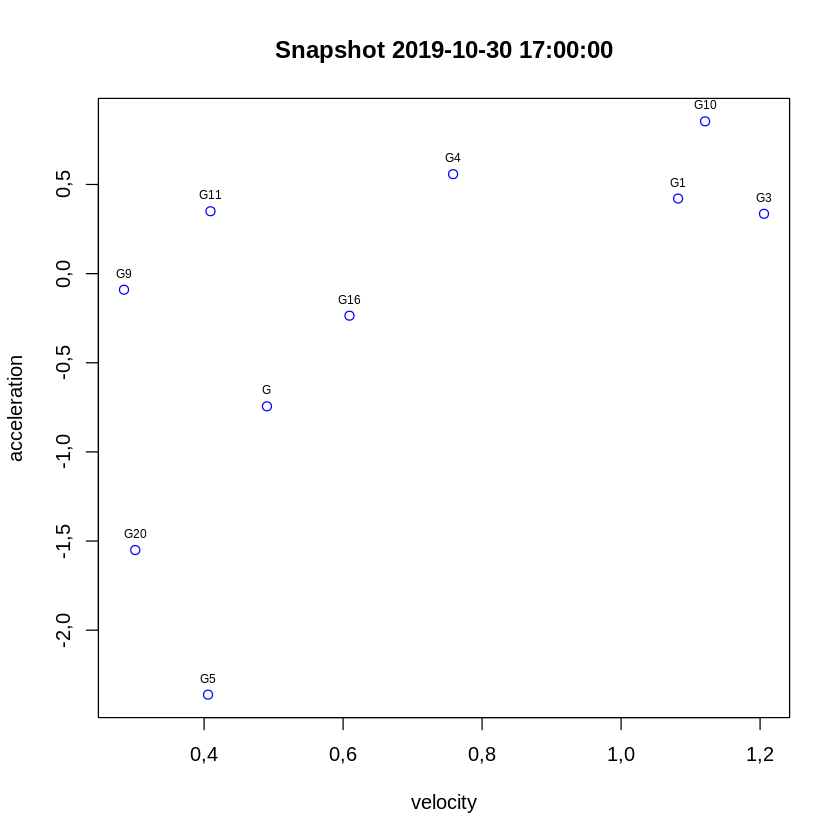

In [46]:
rm(map)
rm(plot_map)
map <- vector(mode="list",10)
plot_map <- vector(mode="list",10)


for (datee in unique(datafile$time_interval)) { 
    
  map[[datee]] <- subset(sva2, snapshot_nbr == datee)  
}    
  
#limit the visualisation of emergency maps, to the one of the studied snapshot
##Studied snapshot: 2019-10-30 17:00:00 => corresponding snapshot number:436792  

plot_map[[436792]] <- plot(map[[436792]]$velocity, map[[436792]]$acceleration, 
                    col = "blue", xlab= "velocity", ylab = "acceleration", 
                    main=sprintf("Snapshot %s",unique(map[[436792]]$creation_date)))
text(map[[436792]]$velocity, map[[436792]]$acceleration, labels=map[[436792]]$graphlet, 
   data=map[[436792]], cex=0.6,pos=3, font=1.5)

# Weak signals qualification

## Contribution ratio calculation per snapshot

In [72]:
rm(ws1) 
rm(ws2)
rm(ws3)
ws2 <- vector(mode = "list", 30)

#remove NULL values from the original graphlets data frame
ws1 <- df[,colSums(is.na(df))<nrow(df)] 
#Calculate the sum of all graphlets number per snapshot
ws1$sumrow <- rowSums(ws1)

#For each column (i.e. graphlet) calculate its contribution
for (k in 1:(ncol(ws1)-1)){
        
   ws2[[k]] <- data.frame(creation_date = rownames(ws1),
                          graphlet = names(ws1)[k],
                          contribution_value = ws1[,k]/ws1[,ncol(ws1)])
}
#Join all graphlets and snapshots in one dataframe
ws3 <- do.call("rbind",ws2)

Based on a selected threshold k (for example equal to 10), choose the top k graphlets having lowest contributions from the obtained list

In [82]:
#Example of displaying the contributions of the studied snapshot, in ascending order

subset(ws3[order(ws3$contribution_value),], creation_date == "2019-10-30 17:00:00")

,creation_date,graphlet,contribution_value
,<fct>,<fct>,<dbl>
201,2019-10-30 17:00:00,G2,"0,000000e+00"
477,2019-10-30 17:00:00,G6,"0,000000e+00"
546,2019-10-30 17:00:00,G7,"0,000000e+00"
615,2019-10-30 17:00:00,G8,"0,000000e+00"
891,2019-10-30 17:00:00,G12,"0,000000e+00"
960,2019-10-30 17:00:00,G13,"0,000000e+00"
1029,2019-10-30 17:00:00,G14,"0,000000e+00"
1098,2019-10-30 17:00:00,G15,"0,000000e+00"
1236,2019-10-30 17:00:00,G17,"0,000000e+00"


# Interpretation and validation of identified weak signals

## Orbits enumeration - nodes positions in weak signal graphlets

In [107]:
rm(orbits_per_graph)  
rm(of)
orbits_per_graph <- vector(mode="list",10) 

for (datee in unique(datafile$time_interval)) { 
        
    ##node level
    orbits_per_graph[[datee]]  <- count_orbits_per_node(interaction_snap[[datee]], 5)
      
    #add nodes as a column
    orbits_per_graph[[datee]]  <- cbind(time_interval = datee,
                                        node = rownames(orbits_per_graph[[datee]]),
                                        orbits_per_graph[[datee]])  
     
    #Add the creation date and time to the obtained node orbits results  
    orbits_per_graph[[datee]]  <- merge(datafile[, c(1,4)], orbits_per_graph[[datee]],
                                      by = "time_interval")
    
         
  }
     
   #Join all timeslices of each episode, then add the Page rank scores for each node  
   of <- do.call("rbind",orbits_per_graph) 


In [108]:
#Example of displaying the orbits of nodes in the studied snapshot
head(subset(of, creation_date == "2019-10-30 17:00:00"))

,time_interval,creation_date,node,O0,O1,O2,O3,O4,O5,O6,⋯,O63,O64,O65,O66,O67,O68,O69,O70,O71,O72
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
113424,436792,2019-10-30 17:00:00,11110093,2,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
113425,436792,2019-10-30 17:00:00,11110323,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
113426,436792,2019-10-30 17:00:00,11110673,5,142,10,0,166,340,4283,⋯,0,0,0,0,0,0,0,0,0,0
113427,436792,2019-10-30 17:00:00,11112751,1,89,0,0,171,0,3916,⋯,0,0,0,0,0,0,0,0,0,0
113428,436792,2019-10-30 17:00:00,11112851,1,89,0,0,171,0,3916,⋯,0,0,0,0,0,0,0,0,0,0
113429,436792,2019-10-30 17:00:00,11113103,2,110,1,0,218,68,4126,⋯,0,0,0,0,0,0,0,0,0,0


## Centralities and communities

### Global Graph creation

In [112]:
rm(interaction_global) 
rm(links_global)
rm(nodes_global) 
  
#Create a graph for all snapshots combined

links_global <-  as.data.frame(datafile %>% 
                               dplyr::group_by(user1,user2) %>%  
                               count() ) 

nodes_global <- as.data.frame(union(links_global$user1,links_global$user2))
colnames(nodes_global) <- "u"

interaction_global <- graph_from_data_frame(links_global, directed = FALSE, vertices = nodes_global)
     
#Display the created graph
interaction_global

IGRAPH 7203c92 UN-- 2369 3820 -- 
+ attr: name (v/c), n (e/n)
+ edges from 7203c92 (vertex names):
 [1] 111163  --2222172            111163  --22224941          
 [3] 111163  --22228390           1111211 --22227570          
 [5] 1111402 --222249650          1111842 --2222143068        
 [7] 1111842 --222230560560132096 11110018--22223103          
 [9] 11110018--22226743           11110093--222256            
[11] 11110093--222268880          11110241--222293098         
[13] 11110323--22226077           11110330--222225427         
[15] 11110330--222233412          11110330--2222700352        
+ ... omitted several edges

### Global centrality calculation - Page Rank algorithm

In [127]:
rm(pg_rank)
rm(gr_centrality)
# Page Rank
pg_rank <- as.data.frame(page_rank(interaction_global, 
                                   vids = V(interaction_global))$vector)

# Add the nodes ID
gr_centrality <- cbind(rownames(pg_rank), pg_rank)
colnames(gr_centrality) <- c("node", "page_rank_score")

#additional column for ranking the Page Rank scores
gr_centrality$page_rank_rank <- rank(-gr_centrality$page_rank_score, ties.method = "first")



In [128]:
#display centrality scores by ascending order
gr_centrality[order(gr_centrality$page_rank_rank),]

,node,page_rank_score,page_rank_rank
,<fct>,<dbl>,<int>
2222143068,2222143068,"0,082526813",1
222263801,222263801,"0,029240905",2
222278395,222278395,"0,015697989",3
111197706,111197706,"0,012800160",4
22228321,22228321,"0,011314611",5
22227823,22227823,"0,010924845",6
222248847,222248847,"0,010517627",7
222230560560132096,222230560560132096,"0,008903960",8
2222762791,2222762791,"0,008591138",9


### Global communities detection - Louvain algorithm

In [130]:
 
gr_louvain <- cluster_louvain(interaction_global)

user_louvain <- cbind(gr_louvain$membership, nodes_global)
colnames(user_louvain) <- c("community", "node") 

#display users by communities
user_louvain[order(user_louvain$community),]

,community,node
,<dbl>,<dbl>
1,1,111163
1666,1,2222172
1667,1,22224941
1668,1,22228390
6,2,11110093
1675,2,222256
1676,2,222268880
9,3,11110330
1679,3,222225427


## Validation of the signals with an event of interest - Cross-Correlation

### Interactions time series vector

In [189]:
interactions_ts <- ts(count_interactions[ , c( 2)] )

### Graphlets time series vectors

Create time series of one column each for the 30 graphlets

In [190]:
rm(graphlet_g)
rm(graphlet_ts)
graphlet_g <- list()
graphlet_ts <- list()

for (i in 1:ncol(df_normalise)){

    graphlet_g[[i]] <- df_normalise[ , c(i)]  
    graphlet_ts[[i]] <- ts(graphlet_g[[i]])
        
}

Remove the columns with NAN values, to prepare for correlation method

In [191]:
rm(graphlets_ts)
graphlets_ts <- do.call("cbind", graphlet_g)

graphlets_ts <- graphlets_ts[,colSums(is.na(graphlets_ts))<nrow(graphlets_ts)]

### Cross Correlation calculation between initial time series and Graphlet X time series

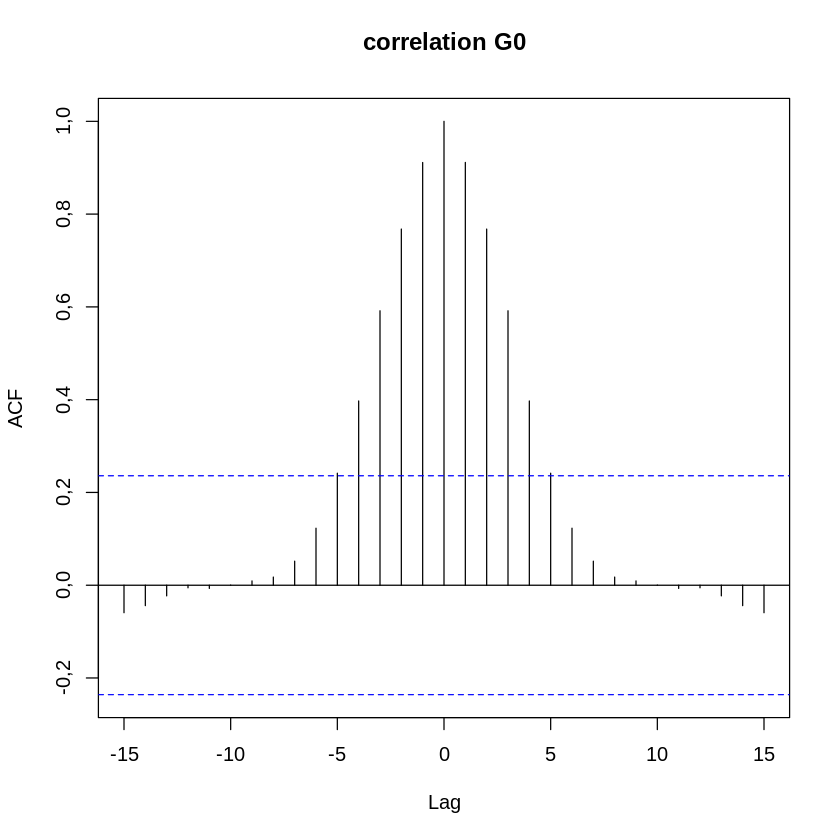

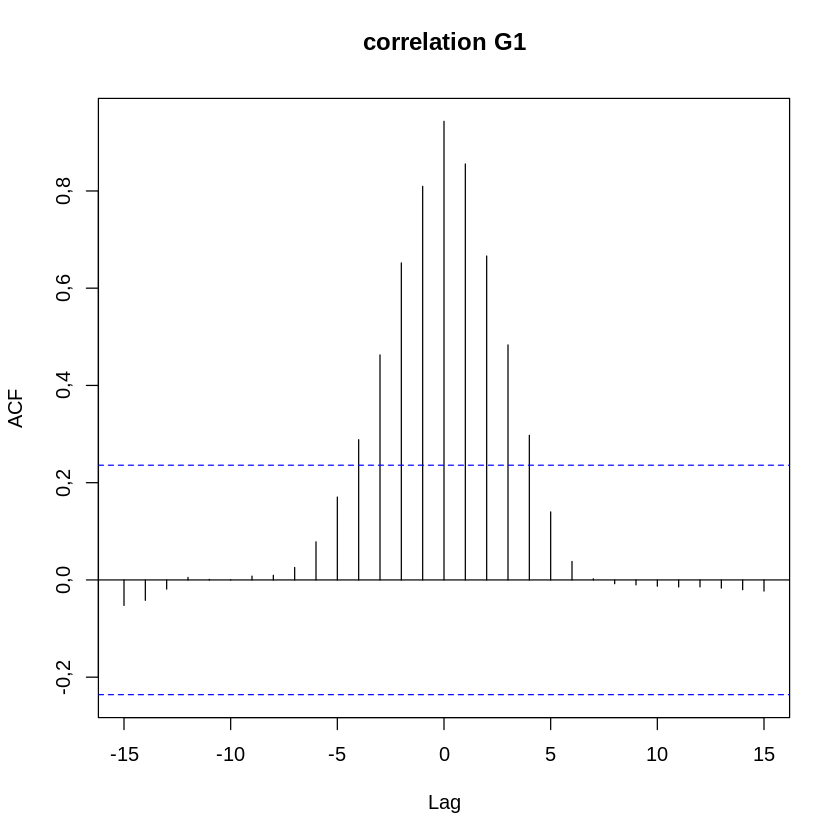

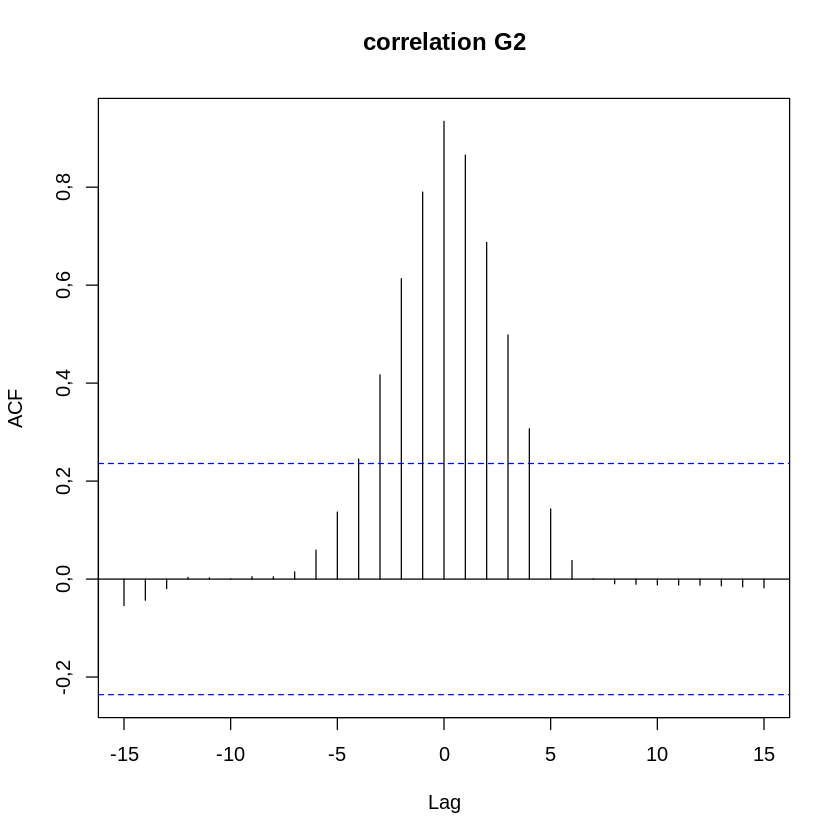

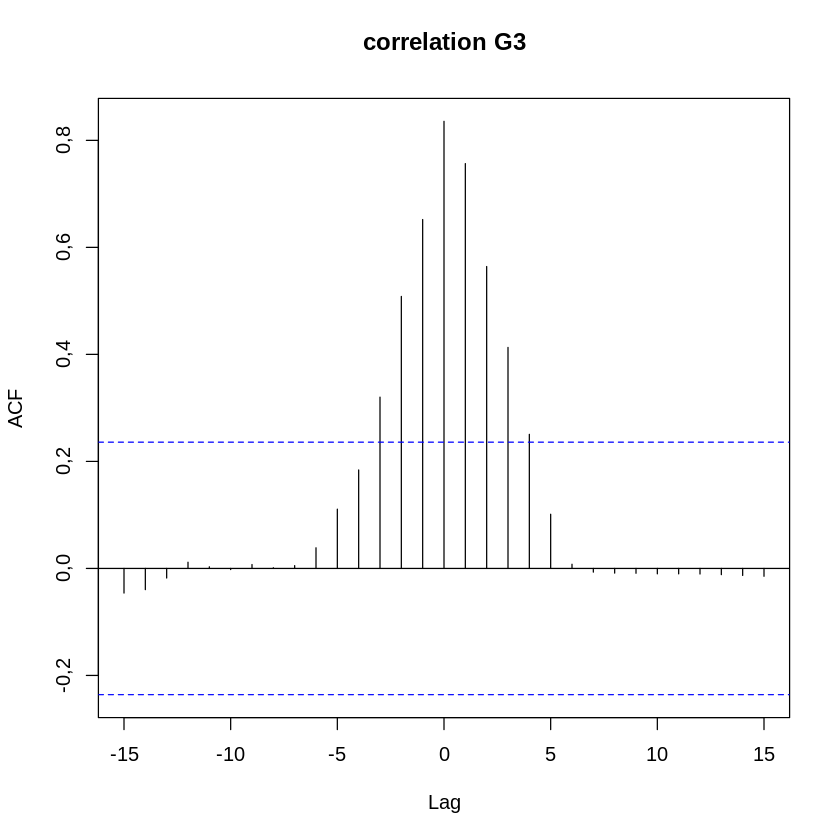

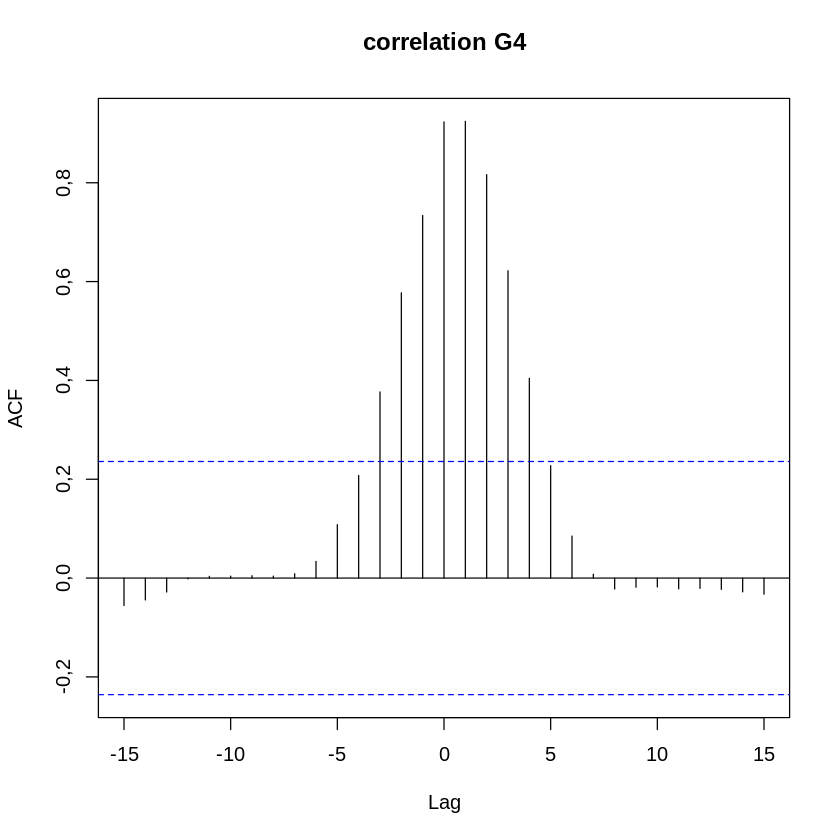

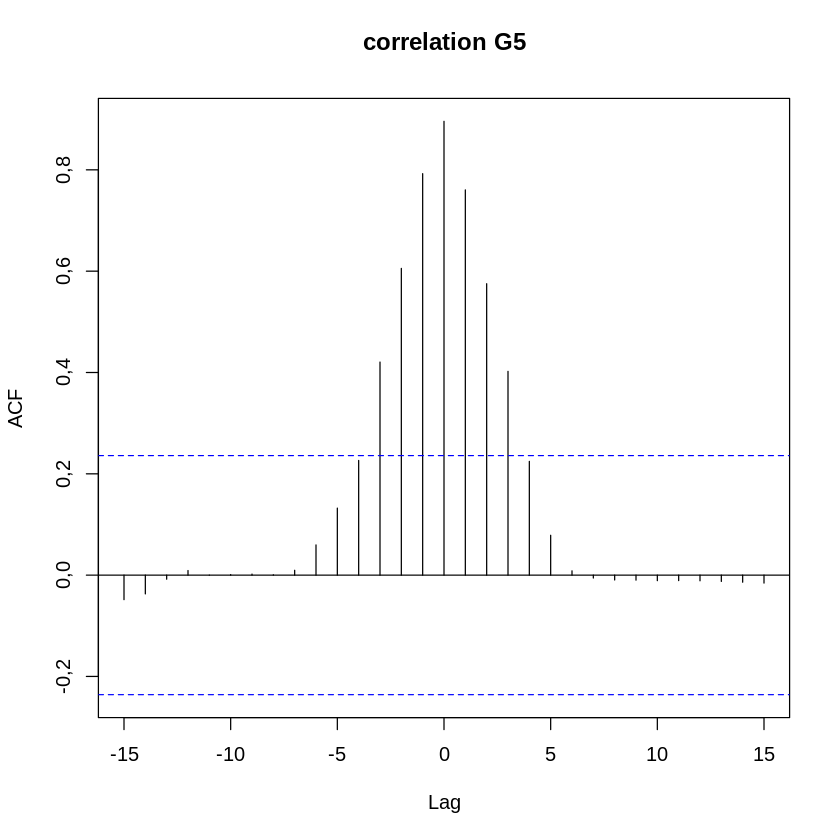

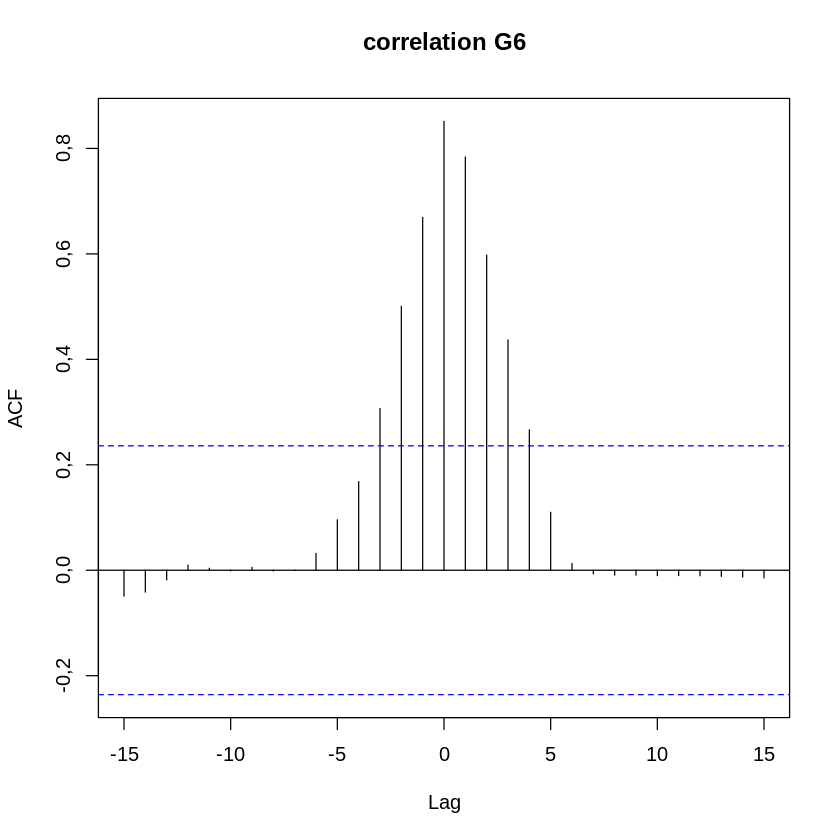

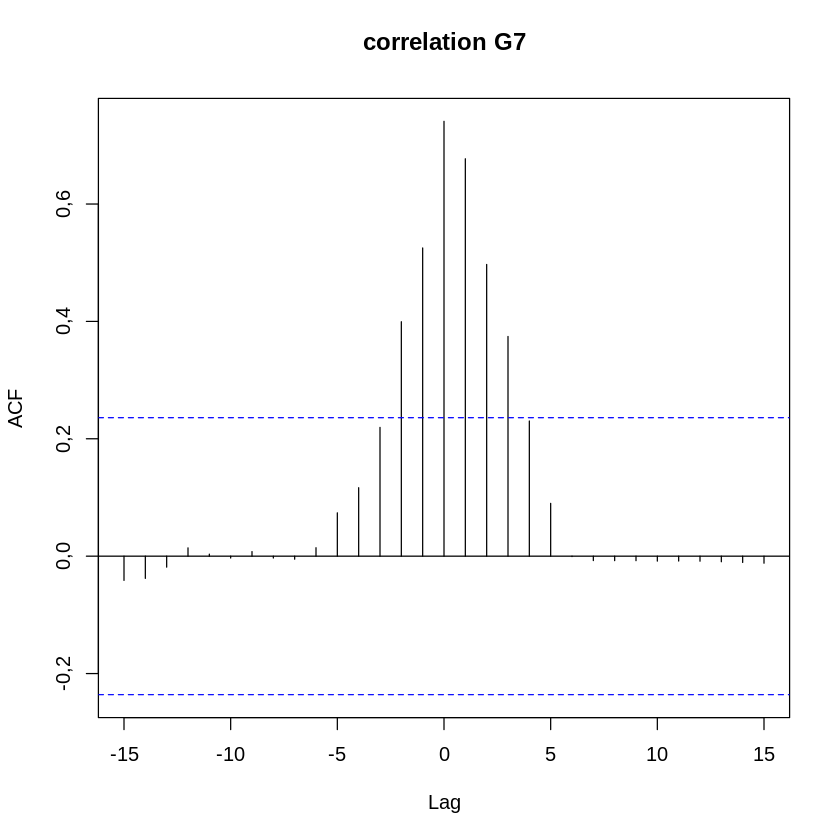

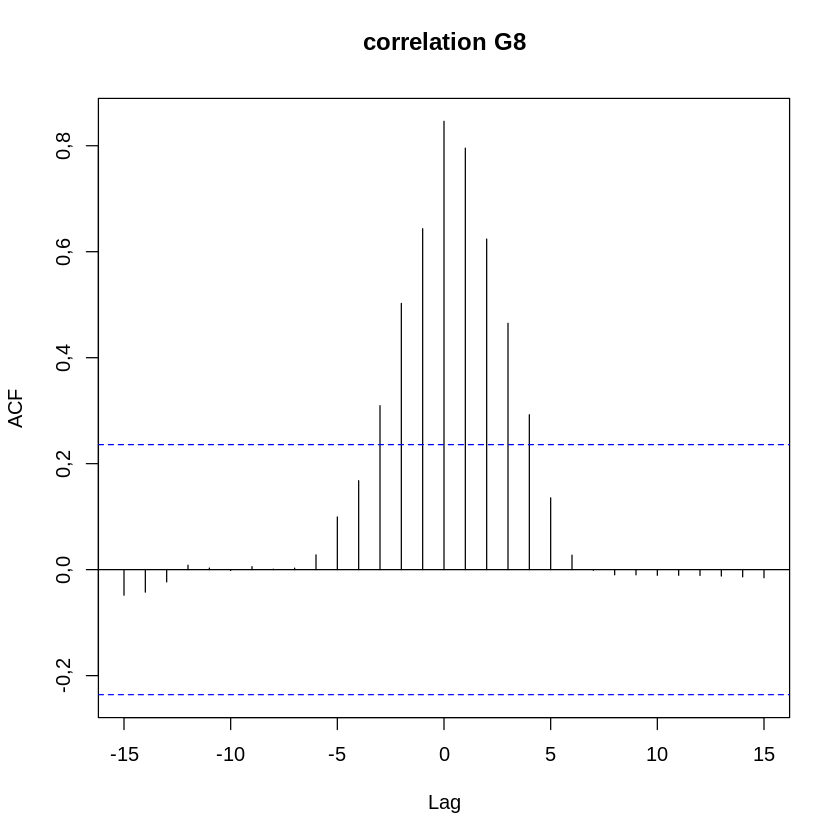

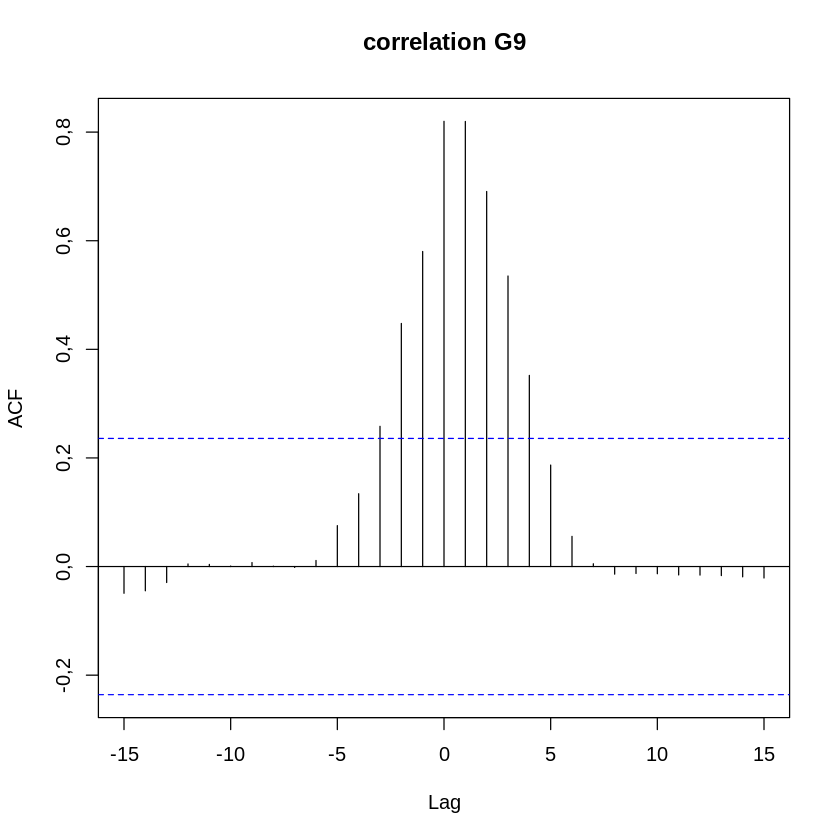

In [192]:
rm(ccfvalues)
rm(graphlets)
ccfvalues <- list()
graphlets <- list()

# the lags are of one hour, per snaphots used
for (i in 1:ncol(graphlets_ts)){

     graphlets[[i]] <- graphlets_ts[ , c(i)]  
     
     #calculate the ccf method for the filled columns of the graphlets data frame
     ccfvalues[[i]] = ccf(count_interactions[ , c( 2)], graphlets[[i]], 
                     main = paste("correlation G", i-1, sep="")) 

}